In [1]:
import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap
import math
import numpy as np
import pandas as pd

1.3474612900804497


In [54]:
sub_ids = [

    "pre4005_y"

]

file_path = 'E:\实验\阅读困难\数据处理\pre4\data\\6epoch_clean_RSA\\'

data_path = file_path + sub_ids[0] + '_RSA-epo.fif'

epochs_all = mne.read_epochs(fname=data_path)

channels_nieye = ['T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']

# 如果只想看某一部分的脑区,配合更改ndarray的维度
epochs_nieye = epochs_all.pick(picks=channels_nieye)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''


Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4005_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1348 matching events found
No baseline correction applied
0 projection items activated


'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

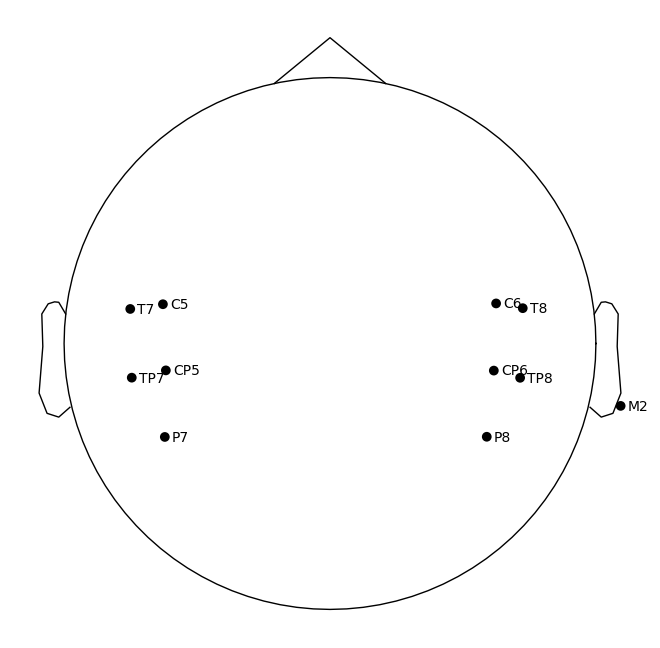

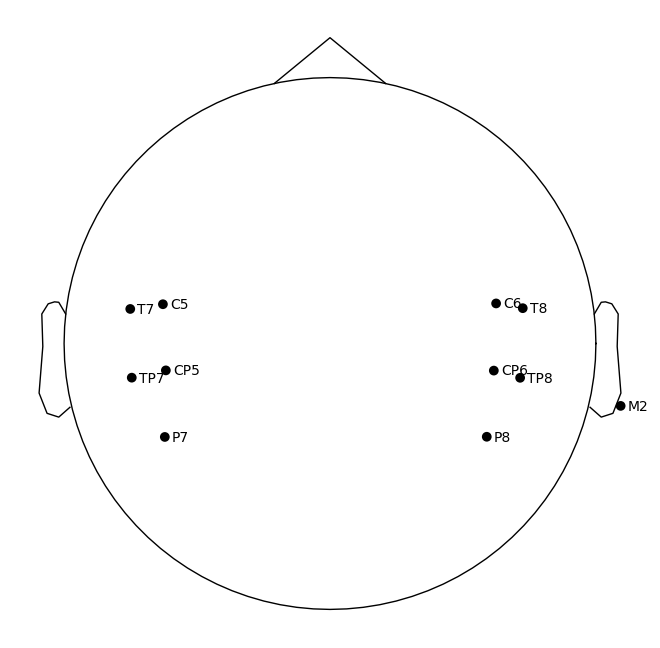

In [55]:
epochs_all.plot_sensors(show_names=True)


In [56]:

'''
生成每种条件对应的evoked
而且是按照次序
'''
conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', ]

# sub_ids = ['pre4002_y',]
eegdata = np.zeros([len(sub_ids),16, 11, 1001], dtype=np.float32)
#初始值
subindex = 0
for m in range(len(sub_ids)):
    #单个被试的数据
    subdata = np.zeros([16, 11, 1001], dtype=np.float32)
    for i in range(len(conds)):
        epochs = epochs_all[conds[i]]
        evoked = epochs.average()
        data = evoked.data
        subdata[i] = data
    eegdata[m] = subdata

In [57]:
# shape of megdata: [n_subs, n_cons, n_chls, n_ts] -> [n_cons, n_subs, n_chls, n_ts]
eegdata = np.transpose(eegdata, (1, 0, 2, 3))

# shape of megdata: [n_cons, n_subs, n_chls, n_ts] -> [n_cons, n_subs, n_trials, n_chls, n_ts]
# here data is averaged, so set n_trials = 1
eegdata = np.reshape(eegdata, [16, len(sub_ids), 1, 11, 1001])



Computing RDM

RDM computing finished!


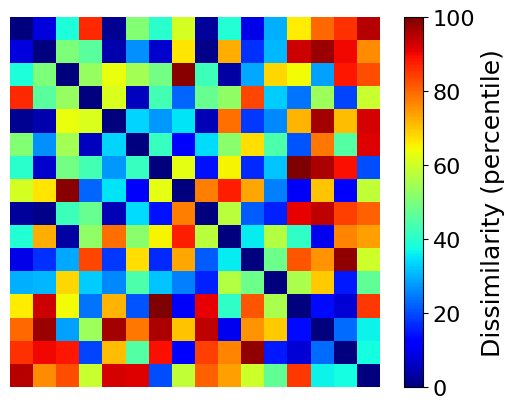

0

In [58]:
# Calculate the RDM based on the data during 190ms-210ms
rdm = eegRDM(eegdata[:, :, :, :, 340:350], sub_opt=0)

# Plot this RDM
plot_rdm(rdm, percentile=True)


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDM computing finished!


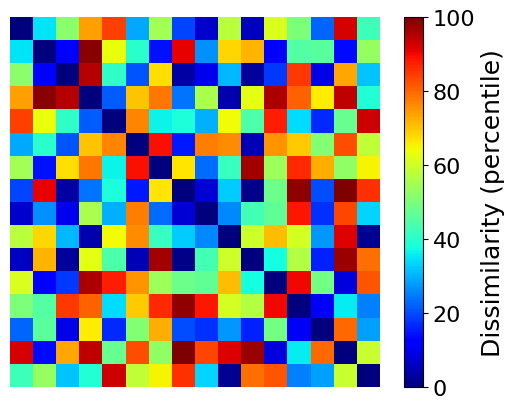

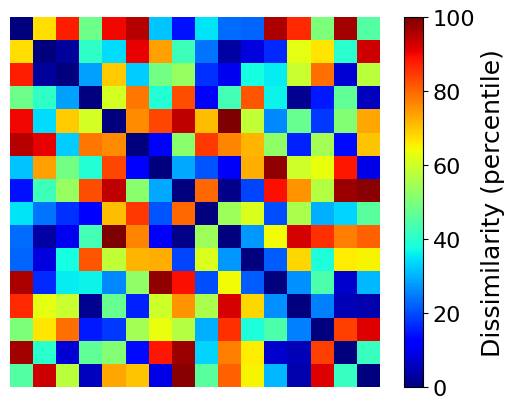

In [59]:
# Calculate the RDMs by a 10ms time-window
# (raw sampling requency is 1000Hz, so here time_win=10ms/(1s/1000Hz)/1000=10)
rdms = eegRDM(eegdata, time_opt=1, time_win=50, time_step=5, sub_opt=0)

# Plot the RDM of -100ms, 0ms, 50ms, 100ms, 150ms, 200ms
times = [0, 10, ]
for t in times:
    plot_rdm(rdms[t], percentile=True)

In [60]:
'''
构造模型矩阵
'''

RDM_model_fuyin = np.zeros([16,16], dtype=np.float32)
# for i in range(20):
#     for j in range(20):
#         if abs(i-j)<=3:
#             RDM_model_fuyin[i,j] = 0
#         else:
#             RDM_model_fuyin[i,j] =
zeroM = np.zeros([4,4], dtype=np.float32)
oneM =  np.ones((4, 4), dtype=np.float32)

a1=np.concatenate((zeroM,oneM,oneM,oneM),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM,),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM,),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM,),axis = 1)
RDM_model_fuyin = np.concatenate((a1,a2,a3,a4),axis=0)



Computing similarities

Computing finished!


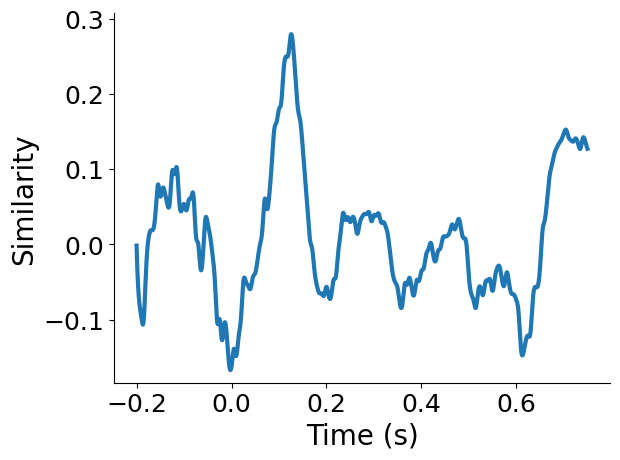

0

In [61]:
# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_fuyin, rdms)


# Plot the corrs1
corrs1 = np.reshape(corrs1, [1, 191, 2])
plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])


Computing similarities

Computing finished!


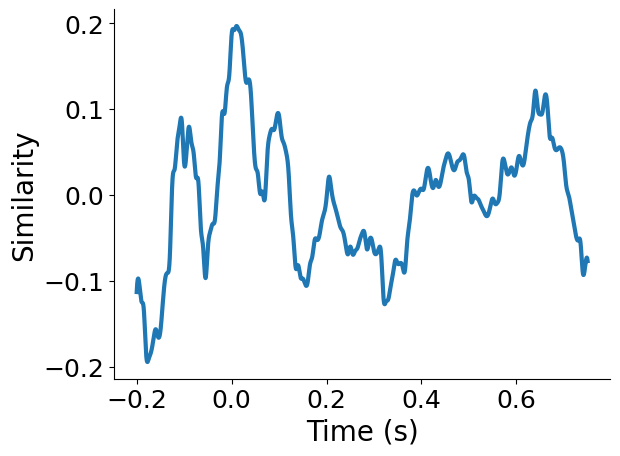

0

In [62]:
'''
构造模型矩阵
'''
RDM_model_yindiao = np.zeros([16,16], dtype=np.float32)

oneM =  np.ones((4, 4), dtype=np.float32)
for i in range(4):
    oneM[i][i] = 0
zeroM = oneM

a1=np.concatenate((zeroM,oneM,oneM,oneM),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM),axis = 1)

RDM_model_yindiao = np.concatenate((a1,a2,a3,a4),axis=0)
# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_yindiao, rdms)


# Plot the corrs1
corrs1 = np.reshape(corrs1, [1, 191, 2])
plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])

In [44]:
'''

更精细的构造方法 slope和height

'''

import math
import numpy as np

df = pd.read_excel('E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\RSA\刺激space\\f0的slope和height.xlsx')

RDM_model_double = np.zeros([20,20], dtype=np.float32)
for i in range(len(df)):

    height1 = df['height'][i]
    slope1 = df['slope'][i]

    for j in range(len(df)):

        height2= df['height'][j]
        slope2 = df['slope'][j]

        '''
        计算公式
        '''
        distance = math.sqrt(math.pow((height2-height1),2)+math.pow((slope2-slope1),2))
        # print(distance)

        '''
        填写到合适的矩阵位置上。
        '''
        RDM_model_double[i][j] = distance


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.


Computing similarities

Computing finished!


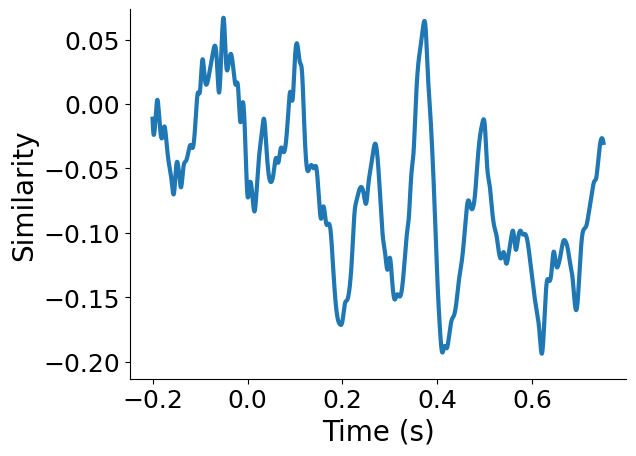

0

In [16]:
# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_double, rdms)

# Plot the corrs1
corrs1 = np.reshape(corrs1, [1, 191, 2])
plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])


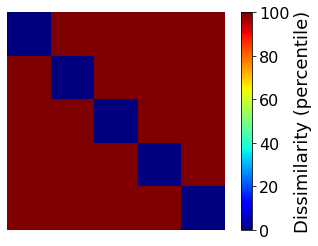

0

In [24]:
plot_rdm(RDM_model_fuyin, percentile=True)

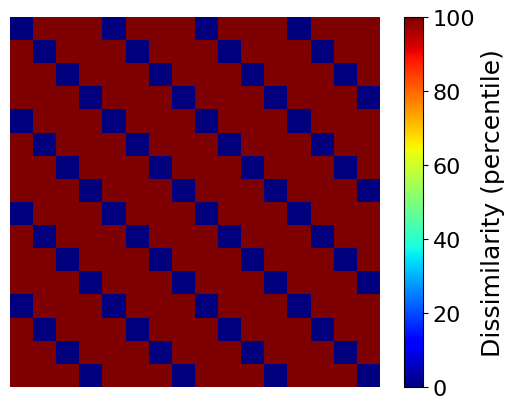

0

In [15]:
plot_rdm(RDM_model_yindiao, percentile=True)

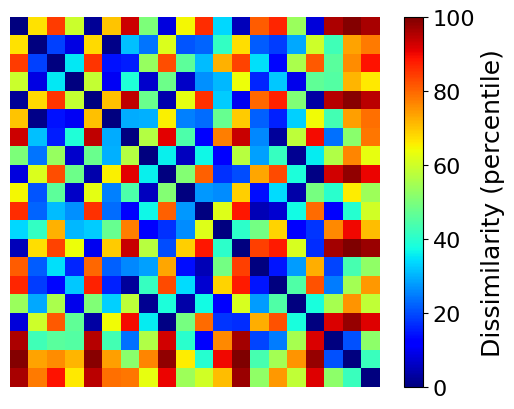

0

In [17]:
plot_rdm(RDM_model_double, percentile=True)